# King Count - Polynomial Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Normalization
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

## Getting data ready
First We'll have some intuition on the data and set the "id" as index value. Also remove duplicate values.

In [2]:
df = pd.read_csv('./kc_house_data.csv')
df.set_index('id', inplace=True)
df = df[~df.index.duplicated(keep='first')]
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


From date which is an object, "str" in this dataset, we'll have to convert to date and take year and month which is important to our model.

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df = df.drop('date', axis=1)
prices = df['price']
df = df.drop('price', axis=1)
df['price'] = prices
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,price
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,221900.0
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,538000.0
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,180000.0
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,604000.0
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,510000.0


Have an intuition on what columns contain null values and what their Dtypes are

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21436 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21436 non-null  int64  
 1   bathrooms      21436 non-null  float64
 2   sqft_living    21436 non-null  int64  
 3   sqft_lot       21436 non-null  int64  
 4   floors         21436 non-null  float64
 5   waterfront     21436 non-null  int64  
 6   view           21436 non-null  int64  
 7   condition      21436 non-null  int64  
 8   grade          21436 non-null  int64  
 9   sqft_above     21436 non-null  int64  
 10  sqft_basement  21436 non-null  int64  
 11  yr_built       21436 non-null  int64  
 12  yr_renovated   21436 non-null  int64  
 13  zipcode        21436 non-null  int64  
 14  lat            21436 non-null  float64
 15  long           21436 non-null  float64
 16  sqft_living15  21436 non-null  int64  
 17  sqft_lot15     21436 non-null  int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,21436.0,3.371571,0.929205,0.0000,3.0000,3.000,4.000,3.300000e+01
bathrooms,21436.0,2.117349,0.769913,0.0000,1.7500,2.250,2.500,8.000000e+00
sqft_living,21436.0,2082.704936,919.146469,290.0000,1430.0000,1920.000,2550.000,1.354000e+04
sqft_lot,21436.0,15135.637852,41538.620606,520.0000,5040.0000,7614.000,10696.250,1.651359e+06
floors,21436.0,1.496198,0.540388,1.0000,1.0000,1.500,2.000,3.500000e+00
waterfront,21436.0,0.007604,0.086871,0.0000,0.0000,0.000,0.000,1.000000e+00
view,21436.0,0.235118,0.767092,0.0000,0.0000,0.000,0.000,4.000000e+00
condition,21436.0,3.410384,0.650235,1.0000,3.0000,3.000,4.000,5.000000e+00
grade,21436.0,7.661737,1.174256,1.0000,7.0000,7.000,8.000,1.300000e+01
sqft_above,21436.0,1790.960440,829.026491,290.0000,1200.0000,1560.000,2220.000,9.410000e+03


In [6]:
(df == 0).sum()

bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21273
view             19320
condition            0
grade                0
sqft_above           0
sqft_basement    13015
yr_built             0
yr_renovated     20526
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
year                 0
month                0
price                0
dtype: int64

Correlation of two values gives a great insight on what features impact the values of each other

In [7]:
df.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,price
bedrooms,1.000000,0.516772,0.577512,0.031719,0.175207,-0.006685,0.079542,0.027896,0.358396,0.478441,...,0.153745,0.018435,-0.153621,-0.010228,0.129836,0.393161,0.029117,-0.010065,-0.000413,0.309007
bathrooms,0.516772,1.000000,0.754422,0.087143,0.499863,0.063734,0.186684,-0.127839,0.664727,0.684994,...,0.505092,0.051101,-0.202958,0.023444,0.221935,0.568194,0.086627,-0.023215,0.005427,0.525453
sqft_living,0.577512,0.754422,1.000000,0.171957,0.352867,0.103902,0.283753,-0.060973,0.762402,0.876683,...,0.316544,0.055084,-0.198621,0.051118,0.239214,0.756205,0.182775,-0.025818,0.010058,0.701993
sqft_lot,0.031719,0.087143,0.171957,1.000000,-0.005950,0.021571,0.075012,-0.009298,0.112541,0.182581,...,0.052447,0.007636,-0.129411,-0.085992,0.229555,0.143650,0.718097,0.005981,-0.002557,0.088895
floors,0.175207,0.499863,0.352867,-0.005950,1.000000,0.023473,0.028211,-0.266543,0.457475,0.522648,...,0.489062,0.005626,-0.058108,0.049279,0.124285,0.278854,-0.011917,-0.018709,0.011864,0.256278
waterfront,-0.006685,0.063734,0.103902,0.021571,0.023473,1.000000,0.403025,0.016607,0.082841,0.072021,...,-0.026537,0.093025,0.030558,-0.014395,-0.042188,0.086558,0.030694,-0.003444,0.007724,0.266961
view,0.079542,0.186684,0.283753,0.075012,0.028211,0.403025,1.000000,0.045051,0.249890,0.166930,...,-0.055153,0.103633,0.087096,0.005671,-0.079720,0.279077,0.072867,0.003066,-0.006918,0.396933
condition,0.027896,-0.127839,-0.060973,-0.009298,-0.266543,0.016607,0.045051,1.000000,-0.148248,-0.160782,...,-0.364947,-0.061136,0.004509,-0.015402,-0.107780,-0.095002,-0.003731,-0.044611,0.021396,0.035089
grade,0.358396,0.664727,0.762402,0.112541,0.457475,0.082841,0.249890,-0.148248,1.000000,0.756068,...,0.445329,0.014357,-0.182675,0.113332,0.196572,0.712507,0.118313,-0.025513,0.005161,0.667496
sqft_above,0.478441,0.684994,0.876683,0.182581,0.522648,0.072021,0.166930,-0.160782,0.756068,1.000000,...,0.422838,0.022666,-0.260420,-0.001652,0.343115,0.731992,0.193413,-0.020437,0.007820,0.605495


<AxesSubplot:>

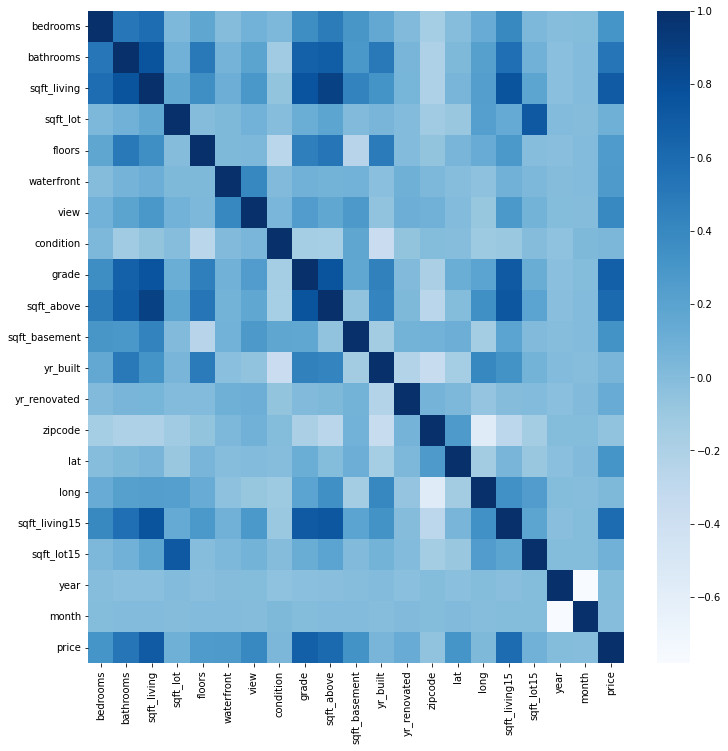

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), cmap='Blues')

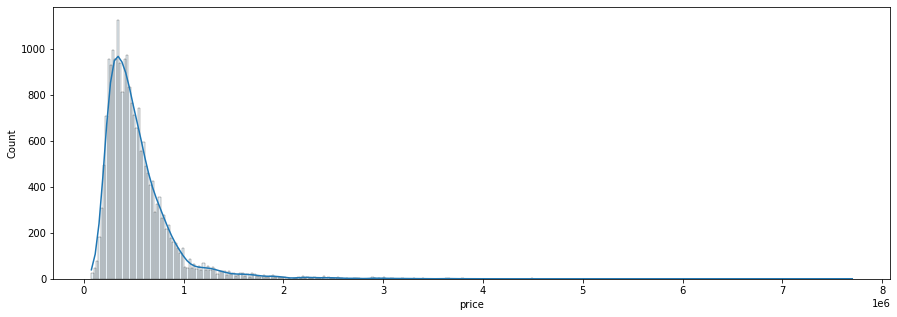

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

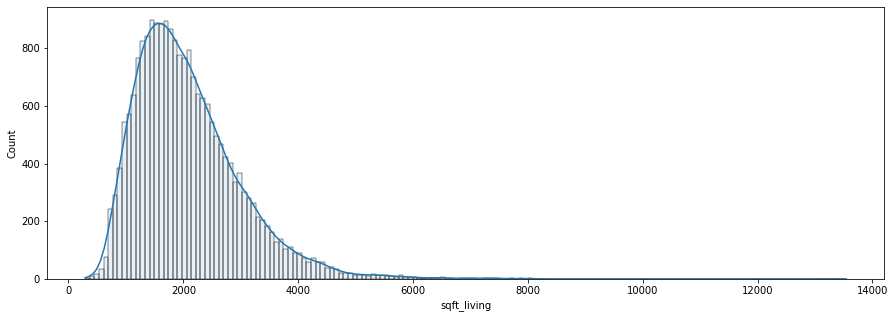

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

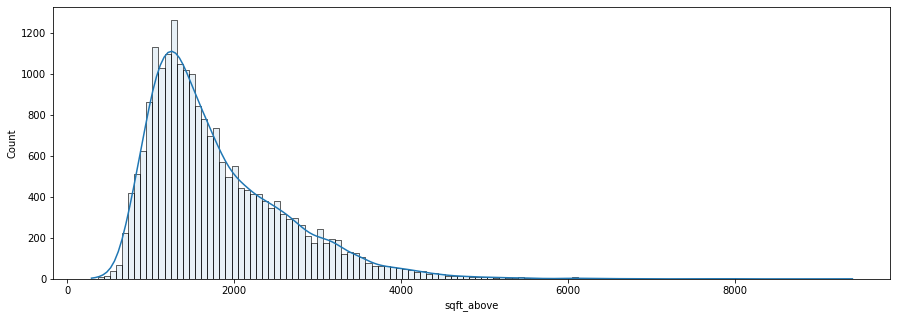

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_above', ax=ax, kde=True, alpha=0.1);

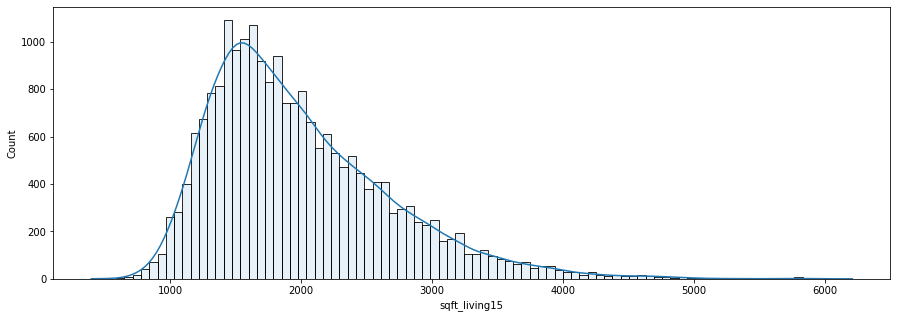

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

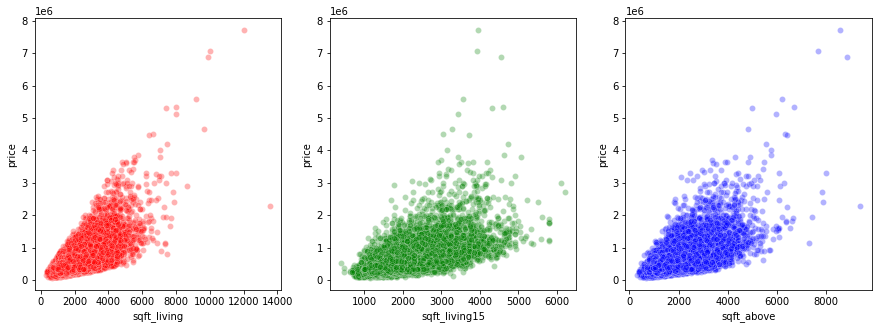

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')
sns.scatterplot(data=df, x='sqft_above', y='price', ax=ax[2], alpha=0.3, color='blue');

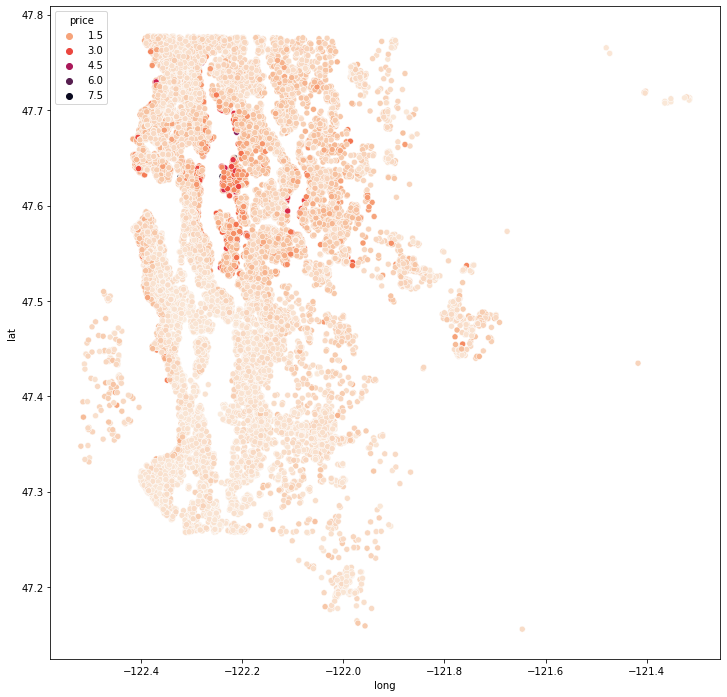

In [14]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

### Should we remove outliers?
For housing prices, a house could have been sold for a value less than what it worths. Or the house could've been sold more than what it worths. According to the red graph, some house with 13.5k sqft_living has been sold for about 2m dollars but some other house with about 12k sqft_living has been sold for about 7.5m dollars. This case could be seen as an outlier but there are other factors that have impact on the price.

In [15]:
df[df['sqft_living'] > 12000].T

id,6762700020,1225069038
bedrooms,6.000000e+00,7.000000e+00
bathrooms,8.000000e+00,8.000000e+00
sqft_living,1.205000e+04,1.354000e+04
sqft_lot,2.760000e+04,3.077520e+05
floors,2.500000e+00,3.000000e+00
waterfront,0.000000e+00,0.000000e+00
view,3.000000e+00,4.000000e+00
condition,4.000000e+00,3.000000e+00
grade,1.300000e+01,1.200000e+01
sqft_above,8.570000e+03,9.410000e+03


Two houses are somewhat the same and in the same area according to their lat and long. <br>
- More expensive one is older than the new one
- More expensive one's grade is greater than the other by 1 values
- sqft_lot15 is very large compared to the other one
- In 1987, the expensive house has been renovated but the other one hasn't been renovated
<br>
Other than these, the other house is better in every aspect. So why it is less expensive or not at all expensive? <br>
I'd say the first one is expensive because it is near the lake.

In [16]:
def remove_outliers(df, columns='all'):
    columns = df.columns if columns == 'all' else columns
    for c in columns:
        df = remove_columns_outlier(df, c)
    return df

def remove_columns_outlier(df, column):
    column = df[column]
    column_norm = (column - np.mean(column)) / np.std(column)
    column_norm = column_norm[~((column_norm >= 3) | (column_norm <= -3))]
    return df.loc[df.index[df.index.value_counts() == 1]]

def remove_outliers_per(df, column, per_column):
    fraction = column / per_column
    frac_norm = (fraction - np.mean(fraction)) / np.std(fraction)
    frac_norm = frac_norm[~((frac_norm >= 3) | (frac_norm <= -3))]
    return df.loc[list(frac_norm.index)]

def drop_tail_right(df, column, from_value, max_percentage=5):
    per = df[df[column] > from_value].size / df.size
    per = per * 100
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    print(f'dropping {per:.2f}% data')
    return df[df[column] <= from_value]

def drop_tail_left(df, column, from_value, max_percentage=5):
    per = df[df[column] < from_value].size / df.size
    per = per * 100
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    print(f'dropping {per:.2f}% of data')
    return df[df[column] >= from_value]

In [17]:
#df = remove_outliers(df, ['price'])
#df = remove_outliers_per(df, df['price'], df['sqft_living'])
#df = remove_outliers_per(df, df['price'], df['sqft_above'])
#df = remove_outliers_per(df, df['price'], df['sqft_living15'])

df = drop_tail_right(df, 'price', 1.4e6)
df = drop_tail_right(df, 'sqft_living', 4000, 3)
df = drop_tail_right(df, 'sqft_living15', 3500, 3)

dropping 2.85% data
dropping 2.13% data
dropping 1.44% data


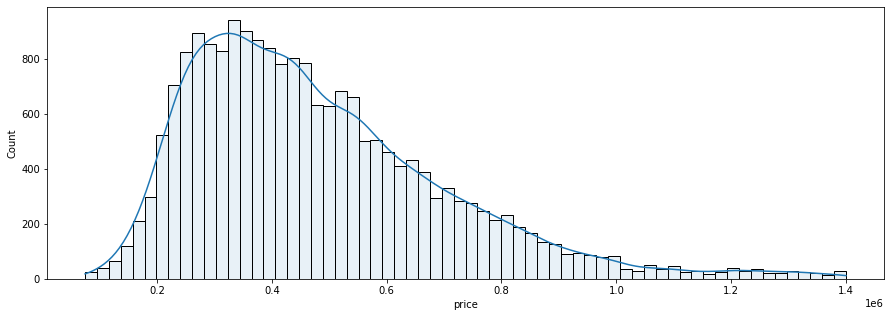

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

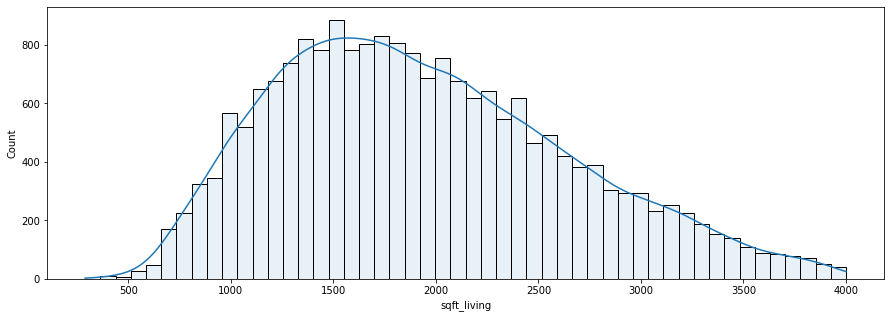

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

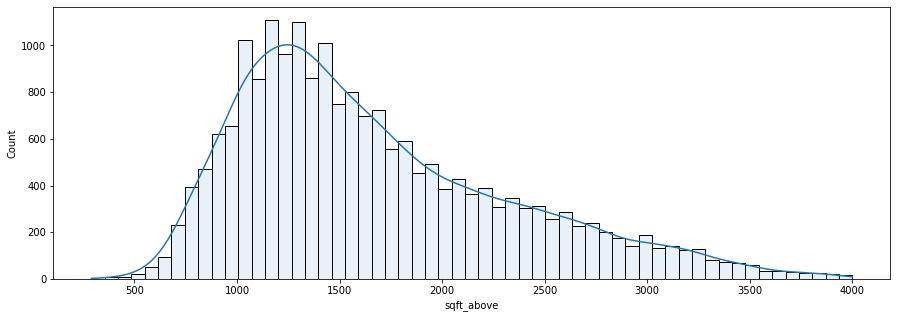

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_above', ax=ax, kde=True, alpha=0.1);

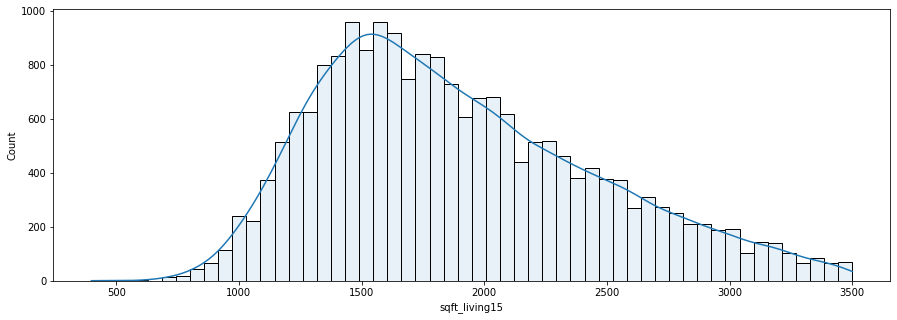

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

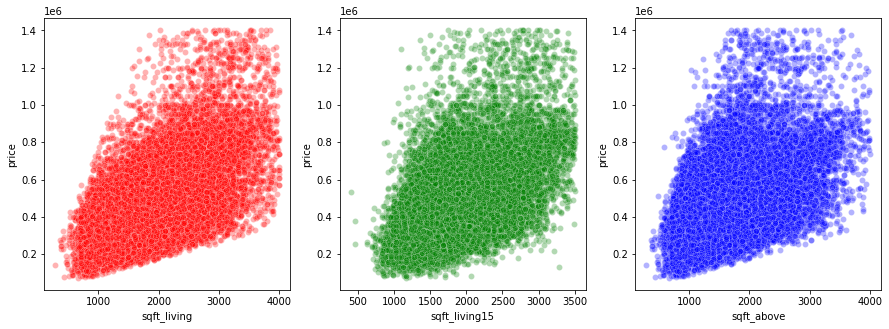

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')
sns.scatterplot(data=df, x='sqft_above', y='price', ax=ax[2], alpha=0.3, color='blue');

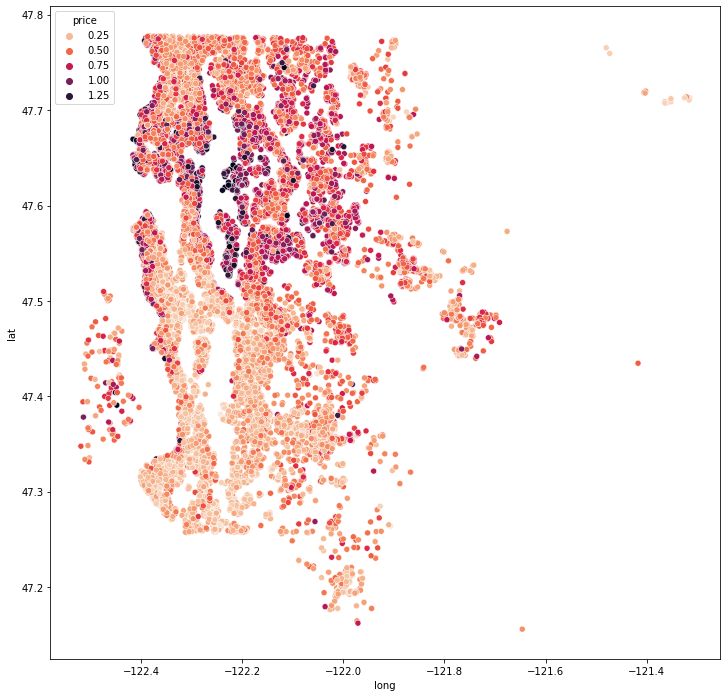

In [23]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

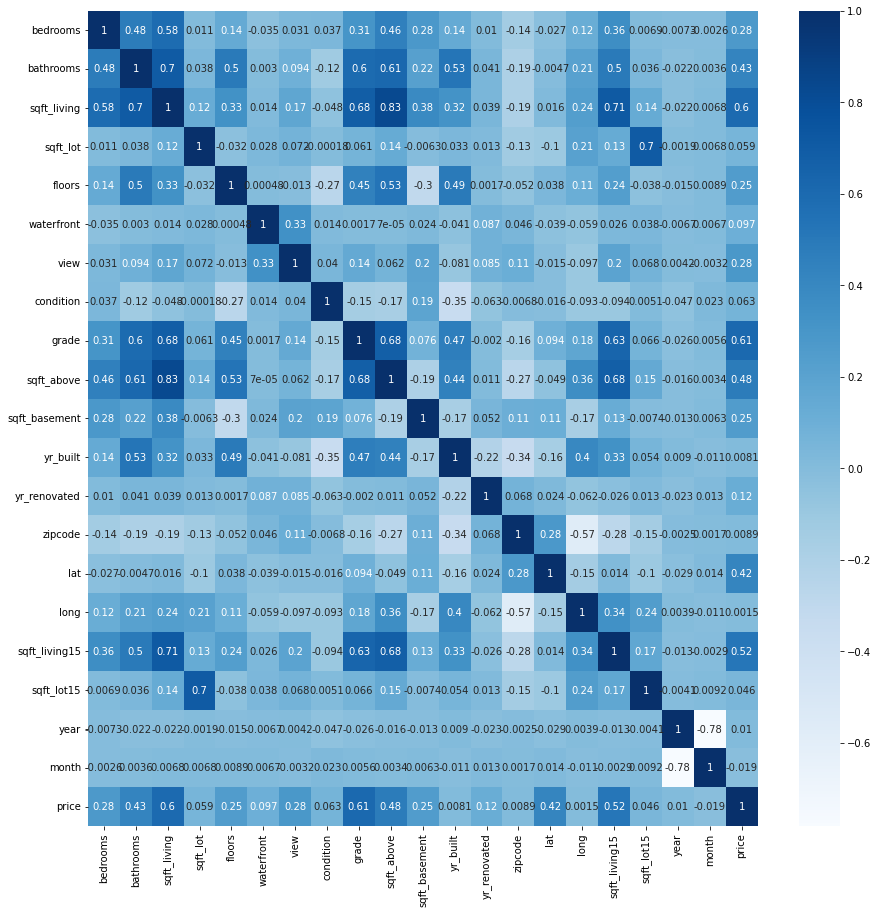

In [24]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), cmap='Blues', annot=True);

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,20088.0,3.315562,0.904915,0.0000,3.000000,3.0000,4.0000,3.300000e+01
bathrooms,20088.0,2.035145,0.691402,0.0000,1.500000,2.0000,2.5000,5.750000e+00
sqft_living,20088.0,1941.087067,711.335860,290.0000,1400.000000,1850.0000,2410.0000,4.000000e+03
sqft_lot,20088.0,13917.687674,37870.479151,520.0000,5000.000000,7450.0000,10164.2500,1.651359e+06
floors,20088.0,1.471251,0.538351,1.0000,1.000000,1.0000,2.0000,3.500000e+00
waterfront,20088.0,0.004032,0.063373,0.0000,0.000000,0.0000,0.0000,1.000000e+00
view,20088.0,0.181750,0.663443,0.0000,0.000000,0.0000,0.0000,4.000000e+00
condition,20088.0,3.416268,0.651927,1.0000,3.000000,3.0000,4.0000,5.000000e+00
grade,20088.0,7.504530,0.998570,1.0000,7.000000,7.0000,8.0000,1.100000e+01
sqft_above,20088.0,1674.490591,669.551195,290.0000,1170.000000,1510.0000,2070.0000,4.000000e+03


## Getting Data ready for trainning

In [25]:
X_train = df.drop(['price'], axis=1).values
y_train = df['price'].values

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly = poly.fit(X_train)
X_train = poly.transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state=10)
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

In [26]:
print(f'X_train shape is {X_train.shape} and y_train shape is {y_train.shape}')
print(f'y_cv shape is {X_cv.shape} and y_cv shape is {y_cv.shape}')
print(f'X_test shape is {X_test.shape} and y_test shape is {y_test.shape}')

X_train shape is (16070, 230) and y_train shape is (16070,)
y_cv shape is (2009, 230) and y_cv shape is (2009,)
X_test shape is (2009, 230) and y_test shape is (2009,)


### Normalize the data

In [27]:
norm = Normalization()
norm.adapt(X_train)
Xn_train = norm(X_train)
Xn_cv = norm(X_cv)
Xn_test = norm(X_test)

## Training

In [28]:
model = SGDRegressor(max_iter=100000, verbose=True, eta0=0.0001, tol=1e-5)
model = model.fit(Xn_train, y_train)

-- Epoch 1
Norm: 37994.44, NNZs: 230, Bias: 83341.960467, T: 16070, Avg. loss: 104487853533.447342
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 44331.07, NNZs: 230, Bias: 131760.567977, T: 32140, Avg. loss: 78087815441.436111
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 47600.59, NNZs: 230, Bias: 169337.413239, T: 48210, Avg. loss: 62772998678.361542
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 49555.10, NNZs: 230, Bias: 200277.144102, T: 64280, Avg. loss: 51961865935.157906
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 51346.38, NNZs: 230, Bias: 226523.262024, T: 80350, Avg. loss: 43859759077.569542
Total training time: 0.05 seconds.
-- Epoch 6
Norm: 52472.47, NNZs: 230, Bias: 249198.838737, T: 96420, Avg. loss: 37571829195.993515
Total training time: 0.06 seconds.
-- Epoch 7
Norm: 52840.54, NNZs: 230, Bias: 269044.221094, T: 112490, Avg. loss: 32594780302.671661
Total training time: 0.07 seconds.
-- Epoch 8
Norm: 53759.78, NNZs: 230, Bias: 286578.089300, T:

Norm: 65816.71, NNZs: 230, Bias: 478157.163489, T: 1285600, Avg. loss: 7733816786.723638
Total training time: 0.81 seconds.
-- Epoch 81
Norm: 65973.59, NNZs: 230, Bias: 478294.621404, T: 1301670, Avg. loss: 7731383253.277029
Total training time: 0.82 seconds.
-- Epoch 82
Norm: 66010.41, NNZs: 230, Bias: 478425.941805, T: 1317740, Avg. loss: 7731167347.673534
Total training time: 0.83 seconds.
-- Epoch 83
Norm: 66147.86, NNZs: 230, Bias: 478550.460295, T: 1333810, Avg. loss: 7729207117.069025
Total training time: 0.84 seconds.
-- Epoch 84
Norm: 66237.64, NNZs: 230, Bias: 478668.991537, T: 1349880, Avg. loss: 7727974954.159605
Total training time: 0.85 seconds.
-- Epoch 85
Norm: 66374.27, NNZs: 230, Bias: 478781.716059, T: 1365950, Avg. loss: 7726534569.062911
Total training time: 0.86 seconds.
-- Epoch 86
Norm: 66509.49, NNZs: 230, Bias: 478889.828881, T: 1382020, Avg. loss: 7725158234.951146
Total training time: 0.87 seconds.
-- Epoch 87
Norm: 66597.70, NNZs: 230, Bias: 478993.063360, 

Norm: 72472.76, NNZs: 230, Bias: 480953.747255, T: 2346220, Avg. loss: 7673006091.799131
Total training time: 1.44 seconds.
-- Epoch 147
Norm: 72548.64, NNZs: 230, Bias: 480960.485167, T: 2362290, Avg. loss: 7672762138.329791
Total training time: 1.45 seconds.
-- Epoch 148
Norm: 72642.70, NNZs: 230, Bias: 480966.344532, T: 2378360, Avg. loss: 7671735679.368539
Total training time: 1.45 seconds.
-- Epoch 149
Norm: 72726.29, NNZs: 230, Bias: 480972.622129, T: 2394430, Avg. loss: 7671553690.669730
Total training time: 1.46 seconds.
-- Epoch 150
Norm: 72811.77, NNZs: 230, Bias: 480977.908790, T: 2410500, Avg. loss: 7670659073.984524
Total training time: 1.47 seconds.
-- Epoch 151
Norm: 72926.14, NNZs: 230, Bias: 480984.094930, T: 2426570, Avg. loss: 7669309771.156529
Total training time: 1.48 seconds.
-- Epoch 152
Norm: 73012.98, NNZs: 230, Bias: 480988.954694, T: 2442640, Avg. loss: 7669805851.268341
Total training time: 1.49 seconds.
-- Epoch 153
Norm: 73086.84, NNZs: 230, Bias: 480994.3

Norm: 78214.05, NNZs: 230, Bias: 481099.469218, T: 3406840, Avg. loss: 7637412150.410250
Total training time: 2.05 seconds.
-- Epoch 213
Norm: 78285.01, NNZs: 230, Bias: 481100.160212, T: 3422910, Avg. loss: 7637292018.883281
Total training time: 2.06 seconds.
-- Epoch 214
Norm: 78370.85, NNZs: 230, Bias: 481100.800977, T: 3438980, Avg. loss: 7636423834.971577
Total training time: 2.07 seconds.
-- Epoch 215
Norm: 78468.72, NNZs: 230, Bias: 481101.550958, T: 3455050, Avg. loss: 7636165774.458437
Total training time: 2.08 seconds.
-- Epoch 216
Norm: 78547.88, NNZs: 230, Bias: 481102.319555, T: 3471120, Avg. loss: 7635826998.446162
Total training time: 2.09 seconds.
-- Epoch 217
Norm: 78683.88, NNZs: 230, Bias: 481103.879309, T: 3487190, Avg. loss: 7633641049.419709
Total training time: 2.09 seconds.
-- Epoch 218
Norm: 78706.97, NNZs: 230, Bias: 481103.970862, T: 3503260, Avg. loss: 7635216119.233117
Total training time: 2.10 seconds.
-- Epoch 219
Norm: 78783.96, NNZs: 230, Bias: 481104.3

Norm: 83201.70, NNZs: 230, Bias: 481116.053007, T: 4451390, Avg. loss: 7611477238.450038
Total training time: 2.66 seconds.
-- Epoch 278
Norm: 83290.25, NNZs: 230, Bias: 481115.907452, T: 4467460, Avg. loss: 7611384193.329996
Total training time: 2.67 seconds.
-- Epoch 279
Norm: 83374.56, NNZs: 230, Bias: 481115.362948, T: 4483530, Avg. loss: 7611224714.677151
Total training time: 2.68 seconds.
-- Epoch 280
Norm: 83450.30, NNZs: 230, Bias: 481115.649538, T: 4499600, Avg. loss: 7610683760.816740
Total training time: 2.69 seconds.
-- Epoch 281
Norm: 83509.78, NNZs: 230, Bias: 481115.200704, T: 4515670, Avg. loss: 7610513236.417306
Total training time: 2.70 seconds.
-- Epoch 282
Norm: 83589.74, NNZs: 230, Bias: 481115.613311, T: 4531740, Avg. loss: 7609963481.354585
Total training time: 2.71 seconds.
-- Epoch 283
Norm: 83681.82, NNZs: 230, Bias: 481115.631736, T: 4547810, Avg. loss: 7609346791.430594
Total training time: 2.72 seconds.
-- Epoch 284
Norm: 83719.47, NNZs: 230, Bias: 481115.3

Norm: 87653.62, NNZs: 230, Bias: 481115.510700, T: 5479870, Avg. loss: 7591133064.386769
Total training time: 3.27 seconds.
-- Epoch 342
Norm: 87755.59, NNZs: 230, Bias: 481115.814624, T: 5495940, Avg. loss: 7591408046.881332
Total training time: 3.29 seconds.
-- Epoch 343
Norm: 87789.08, NNZs: 230, Bias: 481116.509823, T: 5512010, Avg. loss: 7590899483.960711
Total training time: 3.30 seconds.
-- Epoch 344
Norm: 87836.28, NNZs: 230, Bias: 481116.082150, T: 5528080, Avg. loss: 7590505421.750945
Total training time: 3.31 seconds.
-- Epoch 345
Norm: 87916.61, NNZs: 230, Bias: 481115.917489, T: 5544150, Avg. loss: 7590717128.182721
Total training time: 3.32 seconds.
-- Epoch 346
Norm: 87985.64, NNZs: 230, Bias: 481116.640848, T: 5560220, Avg. loss: 7590040736.209255
Total training time: 3.33 seconds.
-- Epoch 347
Norm: 88062.69, NNZs: 230, Bias: 481116.466650, T: 5576290, Avg. loss: 7590161510.021332
Total training time: 3.33 seconds.
-- Epoch 348
Norm: 88130.90, NNZs: 230, Bias: 481116.7

Norm: 91641.80, NNZs: 230, Bias: 481116.809499, T: 6492280, Avg. loss: 7575632219.372024
Total training time: 3.89 seconds.
-- Epoch 405
Norm: 91715.45, NNZs: 230, Bias: 481116.675528, T: 6508350, Avg. loss: 7575340864.905688
Total training time: 3.90 seconds.
-- Epoch 406
Norm: 91746.04, NNZs: 230, Bias: 481116.868910, T: 6524420, Avg. loss: 7574340980.922745
Total training time: 3.91 seconds.
-- Epoch 407
Norm: 91854.28, NNZs: 230, Bias: 481117.490354, T: 6540490, Avg. loss: 7573544188.737360
Total training time: 3.92 seconds.
-- Epoch 408
Norm: 91879.54, NNZs: 230, Bias: 481117.529925, T: 6556560, Avg. loss: 7574632563.643499
Total training time: 3.93 seconds.
-- Epoch 409
Norm: 91965.04, NNZs: 230, Bias: 481117.524569, T: 6572630, Avg. loss: 7574018464.327489
Total training time: 3.94 seconds.
-- Epoch 410
Norm: 92038.92, NNZs: 230, Bias: 481117.861825, T: 6588700, Avg. loss: 7573985741.860945
Total training time: 3.95 seconds.
-- Epoch 411
Norm: 92077.68, NNZs: 230, Bias: 481117.5

Norm: 95217.32, NNZs: 230, Bias: 481119.506966, T: 7472550, Avg. loss: 7562179104.074575
Total training time: 4.50 seconds.
-- Epoch 466
Norm: 95269.09, NNZs: 230, Bias: 481119.608042, T: 7488620, Avg. loss: 7562190546.352873
Total training time: 4.51 seconds.
-- Epoch 467
Norm: 95326.39, NNZs: 230, Bias: 481119.801075, T: 7504690, Avg. loss: 7561928248.365453
Total training time: 4.53 seconds.
-- Epoch 468
Norm: 95387.11, NNZs: 230, Bias: 481119.785426, T: 7520760, Avg. loss: 7561658250.785308
Total training time: 4.54 seconds.
-- Epoch 469
Norm: 95430.69, NNZs: 230, Bias: 481119.786838, T: 7536830, Avg. loss: 7561477463.724603
Total training time: 4.55 seconds.
-- Epoch 470
Norm: 95485.28, NNZs: 230, Bias: 481119.122900, T: 7552900, Avg. loss: 7561022021.125001
Total training time: 4.56 seconds.
-- Epoch 471
Norm: 95545.68, NNZs: 230, Bias: 481118.928180, T: 7568970, Avg. loss: 7560916390.975066
Total training time: 4.57 seconds.
-- Epoch 472
Norm: 95605.86, NNZs: 230, Bias: 481118.8

Norm: 98638.03, NNZs: 230, Bias: 481118.693645, T: 8484960, Avg. loss: 7550305163.783889
Total training time: 5.12 seconds.
-- Epoch 529
Norm: 98677.27, NNZs: 230, Bias: 481118.493981, T: 8501030, Avg. loss: 7549981580.701145
Total training time: 5.13 seconds.
-- Epoch 530
Norm: 98731.83, NNZs: 230, Bias: 481118.450746, T: 8517100, Avg. loss: 7549992021.576936
Total training time: 5.14 seconds.
-- Epoch 531
Norm: 98786.59, NNZs: 230, Bias: 481118.030186, T: 8533170, Avg. loss: 7549914221.598043
Total training time: 5.15 seconds.
-- Epoch 532
Norm: 98830.34, NNZs: 230, Bias: 481117.809004, T: 8549240, Avg. loss: 7549664088.685245
Total training time: 5.16 seconds.
-- Epoch 533
Norm: 98871.97, NNZs: 230, Bias: 481117.496529, T: 8565310, Avg. loss: 7549236548.062803
Total training time: 5.17 seconds.
-- Epoch 534
Norm: 98942.85, NNZs: 230, Bias: 481117.847784, T: 8581380, Avg. loss: 7549047827.283633
Total training time: 5.18 seconds.
-- Epoch 535
Norm: 99001.11, NNZs: 230, Bias: 481118.3

In [29]:
J_abs_train = mean_absolute_error(y_train, model.predict(Xn_train))
J_abs_cv = mean_absolute_error(y_cv, model.predict(Xn_cv))
J_abs_test = mean_absolute_error(y_test, model.predict(Xn_test))

print(f'Absolute error for training set is {J_abs_train}')
print(f'Absolute error for cross validation set is {J_abs_cv}')
print(f'Absolute error for test set is {J_abs_test}')

Absolute error for training set is 90051.08791610872
Absolute error for cross validation set is 88596.77568637209
Absolute error for test set is 90549.9282149638


In [30]:
X_all = df.drop(['price'], axis=1).values
X_all = poly.transform(X_all)
Xn_all = norm(X_all)
p_df = df.copy(deep=True)
p_df['Predicted'] = model.predict(Xn_all).astype('int64')
p_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,price,Predicted
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,0,98178,47.5112,-122.257,1340,5650,2014,10,221900.0,272505
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1991,98125,47.7210,-122.319,1690,7639,2014,12,538000.0,641986
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,0,98028,47.7379,-122.233,2720,8062,2015,2,180000.0,489180
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,0,98136,47.5208,-122.393,1360,5000,2014,12,604000.0,392393
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,0,98074,47.6168,-122.045,1800,7503,2015,2,510000.0,451513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,3,2.50,1530,1131,3.0,0,0,3,8,1530,...,0,98103,47.6993,-122.346,1530,1509,2014,5,360000.0,506272
6600060120,4,2.50,2310,5813,2.0,0,0,3,8,2310,...,0,98146,47.5107,-122.362,1830,7200,2015,2,400000.0,436289
1523300141,2,0.75,1020,1350,2.0,0,0,3,7,1020,...,0,98144,47.5944,-122.299,1020,2007,2014,6,402101.0,234851
